Valeurs manquantes après imputation: 0

=== Performance du modèle ===
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       109
         1.0       0.74      0.80      0.77       105

    accuracy                           0.77       214
   macro avg       0.77      0.77      0.77       214
weighted avg       0.77      0.77      0.77       214

Accuracy: 0.7664


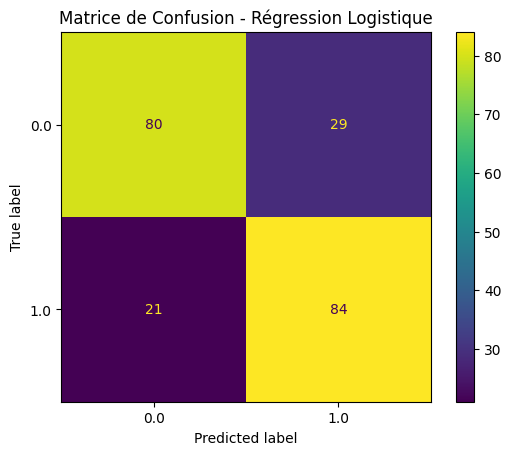

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Chargement des données
df = pd.read_csv('missions_fusionnees.csv')

# 3. Sélection des features
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack'] + time_cols, axis=1, errors='ignore')

# 4. Conversion en valeurs numériques et gestion des NaN
features = features.apply(pd.to_numeric, errors='coerce')

# 5. Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')  # Alternative: 'median' ou 'most_frequent'
features_imputed = imputer.fit_transform(features)

# 6. Vérification des NaN restants
print("Valeurs manquantes après imputation:", np.isnan(features_imputed).sum())

# 7. Split des données
X_train, X_test, y_train, y_test = train_test_split(
    features_imputed, 
    df['is_attack'], 
    test_size=0.3, 
    random_state=42,
    stratify=df['is_attack']
)

# 8. Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 9. Modèle Logistic Regression avec gestion d'erreurs
try:
    lr = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
    lr.fit(X_train_scaled, y_train)
    
    # 10. Évaluation
    y_pred = lr.predict(X_test_scaled)
    
    print("\n=== Performance du modèle ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
    disp.plot()
    plt.title("Matrice de Confusion - Régression Logistique")
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'entraînement: {str(e)}")
    print("\nVérifiez que:")
    print("1. Toutes les colonnes sont numériques")
    print("2. Il n'y a pas de valeurs NaN dans les données")
    print("3. La target ne contient que 0 et 1")

Dimensions initiales: (713, 443)
Dimensions après nettoyage: (713, 443)

RÉGRESSION LOGISTIQUE - Meilleurs paramètres: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
F1-score (validation): 0.8153

Performance sur le test set:
              precision    recall  f1-score   support

         0.0       0.85      0.67      0.75       109
         1.0       0.72      0.88      0.79       105

    accuracy                           0.77       214
   macro avg       0.78      0.77      0.77       214
weighted avg       0.79      0.77      0.77       214



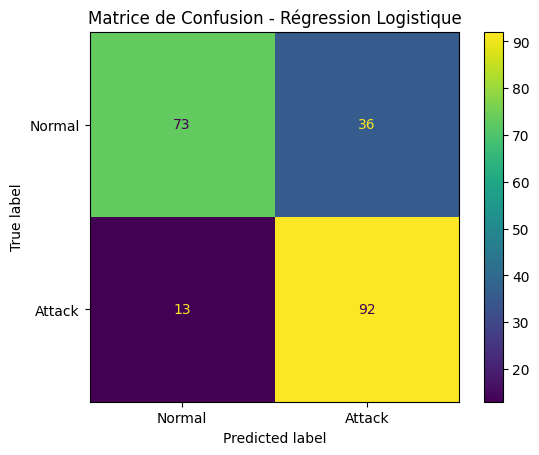

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import joblib
from sklearn.pipeline import Pipeline

# 1. Chargement et inspection des données
df = pd.read_csv('missions_fusionnees.csv')
 
print("Dimensions initiales:", df.shape)
def clean_data(df):
   
    # Conversion des booléens
    bool_cols = df.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)
    
    # Conversion des chaînes de caractères
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            df[col] = df[col].replace({'True':1, 'False':0, 'true':1, 'false':0})
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                df.drop(col, axis=1, inplace=True)
    return df

df = clean_data(df)
print("Dimensions après nettoyage:", df.shape)

# 3. Feature Engineering
def create_features(df):
    # Exemples de nouvelles features
    for i in range(20):
        if f'ax_{i}' in df.columns and f'ay_{i}' in df.columns and f'az_{i}' in df.columns:
            df[f'accel_norm_{i}'] = np.sqrt(df[f'ax_{i}']**2 + df[f'ay_{i}']**2 + df[f'az_{i}']**2)
        if f'velocity_{i}' in df.columns:
            df[f'velocity_diff_{i}'] = df[f'velocity_{i}'] - df['velocity_0']
    
    # Moyennes mobiles
    for var in ['ax', 'ay', 'az']:
        for i in range(10,20):
            cols = [f'{var}_{j}' for j in range(i-5,i) if f'{var}_{j}' in df.columns]
            if cols:
                df[f'{var}_mean_last5_{i}'] = df[cols].mean(axis=1)
    return df

df = create_features(df)

# 4. Préparation des données
time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack','erreur_m'] + time_cols, axis=1, errors='ignore')
target = df['is_attack']

# 5. Pipeline de prétraitement
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = preprocessor.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42, stratify=target)
# Configuration de l'optimisation
logreg_params = {
    'C': [0.01, 0.1, 1, 10],         # Force de régularisation
    'penalty': ['l1', 'l2'],          # Type de pénalité
    'solver': ['liblinear']            # Algorithme d'optimisation
}

# Initialisation et optimisation
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_grid = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
logreg_grid.fit(X_train, y_train)

# Meilleur modèle
best_logreg = logreg_grid.best_estimator_
print("\n" + "="*50)
print(f"RÉGRESSION LOGISTIQUE - Meilleurs paramètres: {logreg_grid.best_params_}")
print(f"F1-score (validation): {logreg_grid.best_score_:.4f}")

# Évaluation
y_pred_logreg = best_logreg.predict(X_test)
y_prob_logreg = best_logreg.predict_proba(X_test)[:,1]

# Métriques
print("\nPerformance sur le test set:")
print(classification_report(y_test, y_pred_logreg))


# Matrice de confusion
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(cm_logreg, display_labels=['Normal', 'Attack'])
disp_logreg.plot()
plt.title("Matrice de Confusion - Régression Logistique")
plt.show()

In [3]:
import joblib

# Sauvegarde du modèle de régression logistique
joblib.dump(best_logreg, 'logistic_regression_model.pkl')
print("✅ Modèle sauvegardé dans 'logistic_regression_model.pkl'")

# Sauvegarde du préprocesseur
joblib.dump(preprocessor, 'preprocessor_lr.pkl')
print("✅ Préprocesseur sauvegardé dans 'preprocessor.pkl'")


✅ Modèle sauvegardé dans 'logistic_regression_model.pkl'
✅ Préprocesseur sauvegardé dans 'preprocessor.pkl'


In [4]:
""""
import numpy as np

# Charger le modèle et le préprocesseur
model = joblib.load('logistic_regression_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')

# Préparer de nouvelles données (en reprenant clean_data et create_features)
df = pd.read_csv('missions_fusionnees.csv')
df = clean_data(df)
df = create_features(df)

time_cols = [col for col in df.columns if col.startswith('time_')]
features = df.drop(['mission_id', 'is_attack', 'erreur_m'] + time_cols, axis=1, errors='ignore')

# Appliquer le prétraitement
X_new = preprocessor.transform(features)

# Prédiction
y_pred = model.predict(X_new)
"""


'"\nimport numpy as np\n\n# Charger le modèle et le préprocesseur\nmodel = joblib.load(\'logistic_regression_model.pkl\')\npreprocessor = joblib.load(\'preprocessor.pkl\')\n\n# Préparer de nouvelles données (en reprenant clean_data et create_features)\ndf = pd.read_csv(\'missions_fusionnees.csv\')\ndf = clean_data(df)\ndf = create_features(df)\n\ntime_cols = [col for col in df.columns if col.startswith(\'time_\')]\nfeatures = df.drop([\'mission_id\', \'is_attack\', \'erreur_m\'] + time_cols, axis=1, errors=\'ignore\')\n\n# Appliquer le prétraitement\nX_new = preprocessor.transform(features)\n\n# Prédiction\ny_pred = model.predict(X_new)\n'